<a href="https://colab.research.google.com/github/anatorres09/DE-MRI_Classificacio_CNN/blob/main/Entrenament_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Connectar a Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#Importar llibreries
import os
from glob import glob
import cv2
import nibabel as nib
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

In [26]:
drive_folder = '/content/drive/MyDrive/CNN'

In [27]:
# Ruta de la carpeta principal
ruta_carpeta_normal = os.path.join(drive_folder, "corr_entrenament", "corr_normal")
ruta_carpeta_patologic = os.path.join(drive_folder, "corr_entrenament", "corr_patologic")

In [28]:
# Redimensionar les imatges a una mida fixa
redimensionar_imatge = (128, 128)

# Recollir imatges i etiquetes de la carpeta corr_normal
def recollir_imatges_etiquetes(ruta_carpeta, etiqueta, redimensionar_imatge):
    casos = [nom_carpeta for nom_carpeta in os.listdir(ruta_carpeta) if os.path.isdir(os.path.join(ruta_carpeta, nom_carpeta))]

    imatges = []
    etiquetes = []

    for cas in casos:
        ruta_cas = os.path.join(ruta_carpeta, cas)
        rutes_imatges = glob(os.path.join(ruta_cas, '*.png'))

        for ruta_imatge in rutes_imatges:
            imatge = cv2.imread(ruta_imatge)
            imatge = cv2.cvtColor(imatge, cv2.COLOR_BGR2RGB)
            
            # Redimensionar les imatges
            imatge = cv2.resize(imatge, redimensionar_imatge)
            
            imatges.append(imatge)
            etiquetes.append(etiqueta)

    return imatges, etiquetes

In [29]:
# Recollir imatges i etiquetes de la carpeta corr_normal
imatges_normal, etiquetes_normal = recollir_imatges_etiquetes(ruta_carpeta_normal, "normal", redimensionar_imatge)

# Recollir imatges i etiquetes de la carpeta corr_patologic
imatges_patologic, etiquetes_patologic = recollir_imatges_etiquetes(ruta_carpeta_patologic, "patologic", redimensionar_imatge)

# Encadenar les llistes d'imatges i etiquetes
imatges_total = imatges_normal + imatges_patologic
etiquetes_total = etiquetes_normal + etiquetes_patologic

# Convertir la llista d'imatges i etiquetes en una matriu numpy
matriu_imatges = np.array(imatges_total, dtype='float32')
etiquetes = np.array(etiquetes_total)

print(f"S'han recollit {matriu_imatges.shape[0]} imatges en total.")

# Obtenir la quantitat de imatges etiquetades com "normal"
quantitat_normal = np.count_nonzero(etiquetes == "normal")

# Obtenir la quntitat de imatges etiquetades com "patologic"
quantitat_patologic = np.count_nonzero(etiquetes == "patologic")

print(f"S'han trobat {quantitat_normal} imatges etiquetades com 'normal'.")
print(f"S'han trobat {quantitat_patologic} imatges etiquetades com 'patologic'.")

S'han recollit 699 imatges en total.
S'han trobat 226 imatges etiquetades com 'normal'.
S'han trobat 473 imatges etiquetades com 'patologic'.


Epoch 1/15
18/18 [==============================] - 3s 40ms/step - loss: 405.4409 - accuracy: 0.6190 - val_loss: 1.2691 - val_accuracy: 0.7500
Epoch 2/15
18/18 [==============================] - 0s 20ms/step - loss: 0.6153 - accuracy: 0.7996 - val_loss: 0.4255 - val_accuracy: 0.8143
Epoch 3/15
18/18 [==============================] - 0s 18ms/step - loss: 0.4535 - accuracy: 0.8372 - val_loss: 0.3004 - val_accuracy: 0.8571
Epoch 4/15
18/18 [==============================] - 0s 18ms/step - loss: 0.2931 - accuracy: 0.8658 - val_loss: 0.2299 - val_accuracy: 0.8857
Epoch 5/15
18/18 [==============================] - 0s 18ms/step - loss: 0.1608 - accuracy: 0.9410 - val_loss: 0.2156 - val_accuracy: 0.9143
Epoch 6/15
18/18 [==============================] - 0s 20ms/step - loss: 0.2635 - accuracy: 0.8891 - val_loss: 0.2261 - val_accuracy: 0.8929
Epoch 7/15
18/18 [==============================] - 0s 20ms/step - loss: 0.1577 - accuracy: 0.9338 - val_loss: 0.2582 - val_accuracy: 0.9000
Epoch 8/15


4867

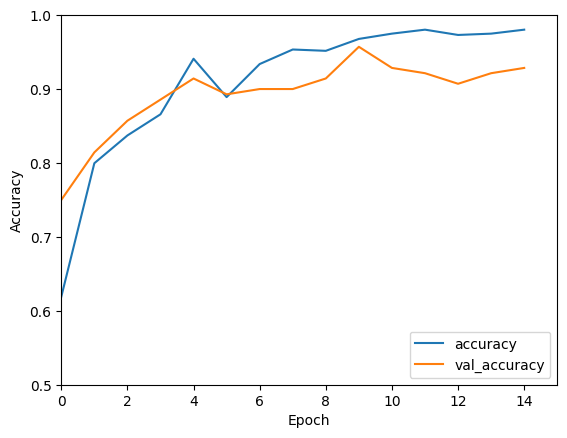

In [30]:
# Preprocessat de les imatges
# Normalitzar els valors de píxels al rang [0, 1]
# imatges = matriu_imatges/ 255.0

# Dividir les dades en conjunts d'entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(matriu_imatges, etiquetes, test_size=0.2, random_state=42)

# Iniciar LabelEncoder
label_encoder = LabelEncoder()

# Ajustar i transformar etiquetes
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convertir etiquetes codificades en codificació one-hot
y_train = tf.one_hot(y_train_encoded, depth=2)
y_test = tf.one_hot(y_test_encoded, depth=2)

# Construir el model de la CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compilar el model
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Crear generadors de dades per l'entrenament i la prova
generador_entrenament = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.3, dtype='float16')
generador_prova = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.3, dtype='float16')

# Crear generadors de fluxe de dades per l'entrenament i la prova
flujo_entrenament = generador_entrenament.flow(X_train, y_train, batch_size=32)
flujo_prova = generador_prova.flow(X_test, y_test, batch_size=32)

# Abans d'entrenar el model
gc.collect()  # Alliberar la memòria abans de l'entrenament

# Crear diccionario de pesos de clase
#class_weights = {0: 0.74, 1: 1.54}

# Entrenar el model utilitzant generadors de dades
#history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

#Ruta de l'arxiu on es guardarà el model
ruta_model = os.path.join(drive_folder, "model_CNN.h5")

# Guardar el model
model.save(ruta_model)
print("Model de la CNN guardat correctament.")

# Avaluar el model en el conjunt de prova utilitzant generador de dades
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pèrdua en el conjunt de prova: {loss}")
print(f"Precisió en el conjunt de prova: {accuracy}")

# Obtenir les prediccions del conjunt de prova
y_pred = model.predict(X_test)

# Convertir les prediccions en etiquetes codificades
y_pred_encoded = np.argmax(y_pred, axis=1)
y_test_encoded = np.argmax(y_test, axis=1)

# Calcular i mostrar la matriu de confussió
confusion_mat = confusion_matrix(y_test_encoded, y_pred_encoded)
print("Matriu de confusió:")
print(confusion_mat)

# Calcular i mostrar l'informe de classificació
classification_rep = classification_report(y_test_encoded, y_pred_encoded)
print("Informe de classificació:")
print(classification_rep)

# Calcular i mostrar la precisió
precision = precision_score(y_test_encoded, y_pred_encoded)
print(f"Precisió: {precision}")

# Calcular i mostrar el recall
recall = recall_score(y_test_encoded, y_pred_encoded)
print(f"Recall: {recall}")

# Calcular i mostrar el F1-score
f1 = f1_score(y_test_encoded, y_pred_encoded)
print(f"F1-score: {f1}")

# Calcular i mostrar l'exactitut (accuracy)
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Exactitut: {accuracy}")



# Gràfics rendiment del model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, 15])
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

# Alliberar la memòria després d'avaluar el model
del X_train, y_train, X_test, y_test
gc.collect()  # Alliberar la memòria utilitzada per les variables eliminades